In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal,sparse
import warnings
warnings.filterwarnings('ignore')

# Source and Flare Detection for Poisson Noise Data

The goal of the project is to detect a "flare" in an image, where both the background and signal have very low detection efficiency. The arrival of photons follows a possion distribution, with both signal and background having an expectency $\ll1$ per pixel.


## Table of contents

- <a href="#statModel">1. Statistical Model</a><br>
    - <a href="#Signaltemplatedetectorresponse">Signal template and simulated detector response</a><br>
    
- <a href="#testStatDerivation">2. Derivation of test statistic</a><br>

    

- <a href="#threshold">3. Calculating consistent threshold values for the flux and the test statistic </a><br>
    - <a href="#thresholdResults">Table of results for different values of parameters</a><br>
    
    
- <a href="#Completeness">5. Completeness of signal detection for both methods</a><br>
    - <a href="#background">As a function of background expectation</a><br>
    - <a href="#positive">As a function of false positive rate</a><br>
    - <a href="#decay">As a function of decay time of flare</a><br>
    - <a href="#PSF">As a function of size of PSF</a><br>


- <a href="#Conclusions">6. Conclusions</a><br>


- <a href="https://github.com/jshlomi/SignalProcessingProject/tree/master/MatlabCode">External link to MATLAB code</a><br>


- <a href="#Code">7. Code</a><br>
    - <a href="#statModelCode">Code for generating signal and background samples</a><br>
    - <a href="#SandFthresholdsCode">Code for calculating threshold values of F and S</a><br>
    - <a href="#CompleteCode">Full code example - generate image+signal for completeness calculation</a><br>

<a id='statModel'></a>

### Statistical model
Our models for the two hypotheses are:

background only:

$H_{0} : M(q) \thicksim poi(q|B)$

background + signal:

$H_{1}(q_{0},F) : M(q) \thicksim poi(B+FPT)$

where $poi(X)$ is the poisson distribution with expected value X, F is some constant number (the flux), P is a point spread function in (x,y) and T is some "flare function" of time. As a convention, we normalize the integral of PT over (x,y,t) to 1. F controls the overall normalisation of the signal strength.

<a id='Signaltemplatedetectorresponse'></a>

#### Signal template and simulated detector response

We used simulated flare-signals in order to test the detection method developed here and compare it to a more naive approach.

The signal template is a Gaussian 2D PSF in the (xy) plane that decays exponentially along the z-axis. By convention it is normalized to 1. 

To simulate the detector response to a signal-flare with a given overall flux F, we first normalize the template signal to F. We then know the flux value per pixel Fp. The probability that the detector receives one or more photons per unit of time then follows the Poisson distribution with mean Fp (assuming 1 unit of time corresponds to one pixel in the z-direction). The detector response at its corresponding pixel is thus randomly generated from Poiss(Fp). 

 <a href="#statModelCode">Code for generating signal and background samples with example plots</a><br>
 
A plot of the signal template (left) and the simulated signal inside a simulated background:


<p float="left">
  <img align="left" src="images/signalTemplate.png" width="300"/> 
  <img align="left" src="images/exampleSimulatedImage.png" width="350"/>
</p>

<a id='testStatDerivation'></a>

### Test statistic
Our test statistic is the log likelihood ratio,

$S = log(\frac{P_{pois}(M|H1)}{P_{pois}(M|H0)} )$

$= log\left(\frac{\Pi_{q}\frac{(B+FPT)^{m_{q}}e^{-(B+FPT)}}{m_{q}!}}{\Pi_{q}\frac{B^{m_{q}}e^{-B}}{m_{q}!}}\right)$

$$= \sum_{q}M_{q}log\left(1+\frac{FPT}{B}\right)$$

If F was known, this test statistic would be optimal. 
But the PDF of S depends on F (the flux) in a non linear way so it can't be factored out and absorbed into the threshold of S.

<a id='threshold'></a>

### Consistent threshold values for the flux and the test statistic

One possibility is to search for signals of a particular flux, if we have some way to estimate it.
Since we are searching for a signal of unknown flux, we need to find some value to use in the filter.
If our data was exactly the signal (FPT) but with the background B subtracted, and we were to multiply it by the filter, the value of S we would get would be:

$S = (F-B)\sum_{q}(PT)_{(q)}log\left(1+\frac{FPT}{B}\right)$

We are sensitive only to a flux which would make this value of S at least equal to the threshold S required for false alarm rate $\beta$. That flux, which self consistently (through the PDF of S), is denoted as the "threshold flux".

So we must solve numerically the system of two equations:

$$\int_{S_{threshold}}^{\infty}PDF_{(S)}dS=\beta$$

$$S_{threshold} = (F_{threshold}-B)\sum_{q}(PT)_{(q)}log\left(1+\frac{F_{threshold}PT}{B}\right)$$

We can start from an intial guess for $F_{threshold}$ as the value of flux that would solve the equation:

$1-\beta = \int_{0}^{F_{threshold}}Pois(f| B\cdot4\pi r^{2} )$

Where r is the typical radius of the signal template psf.

In order to find the threshold S for a given threshold flux, we need to caclulate the PDF of S, which we can do numerically by generating "background only" monte carlo samples, calculating the value of S in each pixel, and making a histogram of S. The code for this iterative procedure can be found <a href="#SandFthresholdsCode">here</a>.

In a "naive" approach we would use the signal template itself as the filter. Here the flux is not a factor in the value of the threshold test statistic, since it factors out.

<a id='thresholdResults'></a>

#### Threshold Results

Some values of $F_{th}$ and $S_{th}$ that were derived are shown in the following table:
The calculations are performed with the python code attached below, and repeated in a seperate MATLAB implementation for verification. The MATLAB results are shown in parentheses next to the python based results.

|B     | $\frac{1}{\tau}$| $\sigma_{PSF}$ |   $\beta$  | $F_{th}$          | $S_{th}$        | naive $S_{th}$ | 
|------|-----------------|----------------|------------|-------------------|-----------------|----------------| 
|0.005 | 0.2             | 2.0            |  $10^{-3}$ | 6.15   ( 5.76  )  | 7.01   (7.33 )  | 0.015  (0.017) | 
|0.005 | 0.5             | 2.0            |  $10^{-3}$ | 4.76   ( 4.63  )  | 6.92   (6.73 )  | 0.026  (0.026) | 
|0.005 | 0.8             | 2.0            |  $10^{-3}$ | 4.04   ( 4.03  )  | 6.69   (6.67 )  | 0.034  (0.034) | 
|0.005 | 0               | 2.0            |  $10^{-3}$ | 7.43   ( 6.18  )  | 7.77   (7.39 )  | 0.011  (0.014) | 
|0.005 | 0.5             | 2.0            |  $10^{-5}$ | 6.94   ( 7.43  )  | 11.98  (13.34)  | 0.042  (0.044) | 
|0.005 | 0.5             | 2.0            |  $10^{-1}$ | 1.40   ( 1.40  )  | 1.05   (1.05 )  | 0.007  (0.007) | 
|0.05  | 0.5             | 2.0            |  $10^{-3}$ | 11.85  ( 11.73 )  | 7.89   (7.91 )  | 0.059  (0.060) | 
|0.1   | 0.5             | 2.0            |  $10^{-3}$ | 16.06  ( 15.80 )  | 8.18   (8.16 )  | 0.080  (0.080) | 
|0.005 | 0.5             | 3.0            |  $10^{-3}$ | 6.48   ( 6.28  )  | 7.35   (7.09 )  | 0.015  (0.015) | 
|0.005 | 0.5             | 4.0            |  $10^{-3}$ | 7.48   ( 7.77  )  | 6.91   (7.45 )  | 0.010  (0.011) | 


where the decay constant $\frac{1}{\tau}$ and the PSF standard deviation $\sigma_{PSF}$ are given in pixels. 

In each case, the PDF of S was estimated from $3\times 10^6$ distinct values of S. (for both python and MATLAB versions). in order to estimate the uncertainity on the values of $F_{th}$ and $S_{th}$ we repeated the procedure 100 times, the distribution of results is shown in the following plot:

<p float="left">
  <img align="center" src="images/FthClosure.png" width="900"/> 
</p>

we can see that the results from MATLAB and python code are consistent within the typical spread of threshold values.

An example of the distribution of S (left) and the distribution of S when using the template itself as the filter (right):

<p float="left">
  <img align="left" src="images/PDF_of_S.png" width="450"/> 
  <img align="left" src="images/PDF_of_naiveS.png" width="450"/>
</p>

<a id='Completeness'></a>

### Completeness of signal detection for both methods

In order to calculate the true positive rate (the completeness), we can generate multiple images containing signals, and check if the value of the test statistic evaluated at the signal location passes the threshold.

The results for a variety of values of B, $\frac{1}{\tau}$, $\sigma_{PSF}$ and $\beta$ are shown below. 

The completeness at each flux value was estimated based on $1\times10^5$ distinct tries.

<a id='background'></a>

#### Completeness as a function of background expectation

<img align="left" src="images/B.png" width="900"/> 


<a id='positive'></a>

#### Completeness as a function of false positive rate

<img align="left" src="images/beta.png" width="900"/> 


<a id='decay'></a>

#### Completeness as a function of decay time of flare

<img align="left" src="images/decaycst.png" width="900"/> 


<a id='PSF'></a>

#### Completeness as a function of size of PSF

<img align="left" src="images/psfwidth.png" width="900"/> 


<a id='Conclusions'></a>

### Conclusions

Using the method derived here provides better signal detection efficiency for a given $\beta$ compared to using the signal template as a filter. The magnitude of the improvement depends on how far from the gaussian approximation the background is, and how low we wish to set the false positive rate.

<a id='Code'></a>

## Code
**Note:** We present here the different functions we used to generate the results above. But due to performance issues, we only give examples of running them with low statistics. A simple framework to submit jobs to the cluster was developped and used to produce the results presented above.

The code for running jobs with higher stats can be found here: - <a href="https://github.com/jshlomi/SignalProcessingProject">Link</a><br>

- <a href="https://github.com/jshlomi/SignalProcessingProject/tree/master/MatlabCode">External link to MATLAB code</a><br>

**List of parameters**

In [2]:
Nxy=100 ## Dimension of large image - xyplane - defines the statistics used to calculate PDF of S
Nt=80 ## Dimension of large image - tplane - defines the statistics used to calculate PDF of S
Mxy=20 ## Dimension of template - xyplane
Mt=16 ## Dimension of template - tplane
B=0.005 ## Noise expectation value
decaycst=0.5 ## Decay constant of template signal
F=5 ## Default norm of template signal
psfwidth=2 ## PSF width
x_tsig,y_tsig,z_tsig=(20,40,60) ## Location of template signal
beta=0.001 ## False positive alarm rate
Ntries=1000 ## Number of tries for completeness

<a id='statModelCode'></a>

**List of functions and example use**

In [3]:
## Plot 2D colormap plot of 3D array sliced at desired axis and axis value
def make2Dsliceplot(ar3D,slax,val,title):
    if slax=='x': ar2D=ar3D[val,:,:]
    if slax=='y': ar2D=ar3D[:,val,:]
    if slax=='z': ar2D=ar3D[:,:,val]
    fig=plt.figure()
    ax=fig.add_subplot(111)
    plt.imshow(ar2D,cmap='viridis',interpolation='nearest')
    plt.colorbar(orientation='vertical')
    plt.title("%s for %s=%s"%(title,slax,val))
    
##Parameters
## ar3D : the 3D array
## slax : axis to slice on, either 'x','y' or 'z'
## val : axis value to slice on
## title : plot description

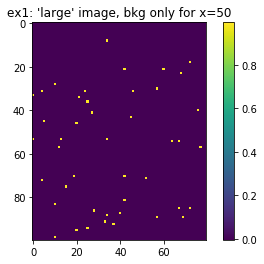

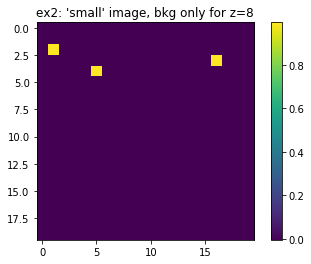

In [6]:
## Return 3D image filled with noise, substract average, add signal
def makeImage(size,ssig=None,noise_avg=None,x=x_tsig,y=y_tsig,z=z_tsig):
    if size=='large': nx=Nxy; ny=Nxy; nt=Nt;
    elif size=='small': nx=Mxy; ny=Mxy; nt=Mt;
    else: print "size:",size
    image=np.random.poisson(B,(nx,ny,nt))
    if size=='large' and noise_avg is None:
        noise_avg=np.mean(image)
        returnAVG=True
    else:
        returnAVG=False
    image=image-noise_avg
    if not ssig is None:
        for i in range(Mxy):
            for j in range(Mxy):
                for t in range(Mt):
                    if size=='large':
                        image[i+x-Mxy/2][j+y-Mxy/2][t+z-Mt/2]+=ssig[i][j][t]
                    else:
                        image[i][j][t]+=ssig[i][j][t] ## image and ssig have the same size
    if returnAVG:
        return image,noise_avg
    else: 
        return image

## Parameters:
## size : size of returned image. If size=='large' -> Nxy*Nxy*Nt ; If size == 'small' -> Mxy*Mxy*Mt
## noise_avg : average of the bkg to be substracted ; when left to None it is calculated from current generated image
## ssig : simulated signal to add to the bkg filled image, must be of dimension Mxy*Mxy*Mt. Default is None
## x,y,z: index location of where to add the signal - relevant only if size == 'large' and ssig is not None

## Note:
## The first time we run this function is to generate a 'large' image with bkg only, and we calculate the noise_avg 
## value that will be substracted everytime this function is called again

## Examples:
ex1,noise_avg=makeImage('large')
make2Dsliceplot(ex1,'x',Nxy/2,"ex1: 'large' image, bkg only")
ex2=makeImage('small',noise_avg=noise_avg)
make2Dsliceplot(ex2,'z',Mt/2,"ex2: 'small' image, bkg only")

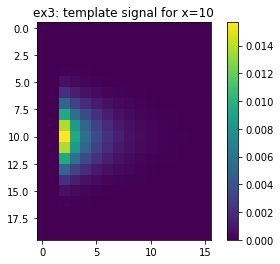

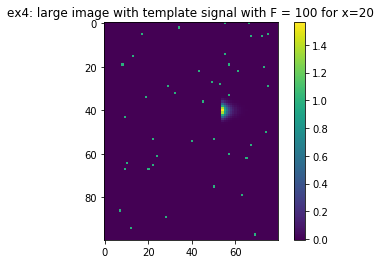

In [7]:
## Return normalized template signal of size Mxy*Mxy*Mt
## The template signal is a PSF in the xy plane and exponentially decaying in the z-direction
def makeTemplate():                                                                                                                           
    tsig=np.zeros((Mxy,Mxy,Mt))
    for t in range(2,Mt):
        tnorm=np.exp(-decaycst*t)
        for i in range(Mxy):
            for j in range(Mxy):
                tsig[i][j][t]=(tnorm/np.sqrt(2*np.pi*psfwidth**2))*np.exp(-((i-Mxy/2.)**2+(j-Mxy/2.)**2)/(2*psfwidth**2))
    tsig/=float(np.sum(tsig))
    return tsig

## Example:
ex3=makeTemplate()
make2Dsliceplot(ex3,'x',Mxy/2,"ex3: template signal")
ex4=makeImage('large',100*ex3,noise_avg=noise_avg)
make2Dsliceplot(ex4,'x',x_tsig,"ex4: large image with template signal with F = 100")

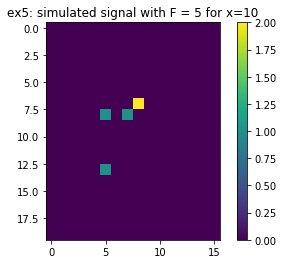

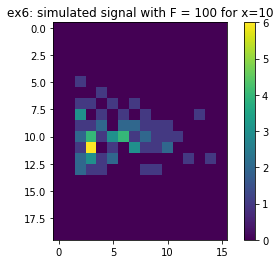

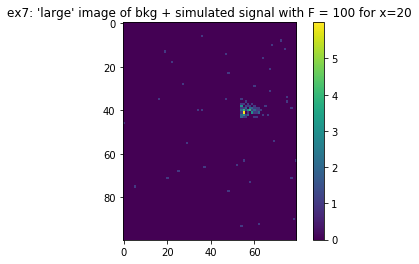

In [8]:
## Return simulated signal from template
## This simulates the detector response to the template signal scaled to a given flux
def makeSimSignal(tsig,f=None,t=None):                                               
    if f is None: f=F
    if t is None: t=1
    ssig=np.zeros((Mxy,Mxy,Mt))
    for i in range(Mxy):
        for j in range(Mxy):
            for t in range(Mt):
                ssig[i][j][t]=np.random.poisson(f*t*tsig[i][j][t])
    return ssig

## Parameters:
## tsig is the template signal from above
## f is the desired overall signal flux, default is F
## t is the exposition time between two images, default is 1

## Examples:
ex5=makeSimSignal(ex3,5)
make2Dsliceplot(ex5,'x',Mxy/2,"ex5: simulated signal with F = 5")
ex6=makeSimSignal(ex3,100)
make2Dsliceplot(ex6,'x',Mxy/2,"ex6: simulated signal with F = 100")
ex7=makeImage('large',ex6,noise_avg=noise_avg)
make2Dsliceplot(ex7,'x',x_tsig,"ex7: 'large' image of bkg + simulated signal with F = 100")

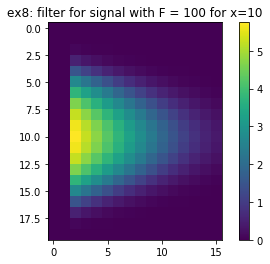

In [9]:
## Return filter for Poisson matched filtering based on formula described above
def makeFilter(tsig,flux=None):                                                                                                                                               
    if flux is None: flux=F
    filt=np.zeros((Mxy,Mxy,Mt))
    for i in range(Mxy):
        for j in range(Mxy):
            for t in range(Mt):
                filt[i][j][t]=np.log(1+flux*tsig[i][j][t]/B)
    return filt

## Parameters:
## tsig : template signal
## flux : desired overall signal flux, defaults as F_init

## Example:
ex8=makeFilter(ex3,100)
make2Dsliceplot(ex8,'x',Mxy/2,"ex8: filter for signal with F = 100")

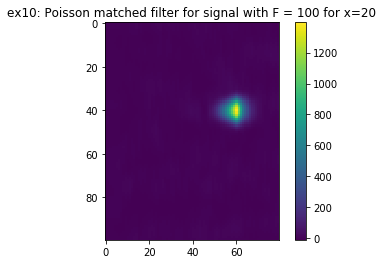

In [10]:
## Return built-in cross-correlation between two arrays
def crossCorrelate(image,filt):
    ## cross-correlate image and filter
    mf=signal.correlate(image,filt,'same')
    return mf

## Example:
ex10=crossCorrelate(ex7,ex8)
make2Dsliceplot(ex10,'x',x_tsig,"ex10: Poisson matched filter for signal with F = 100")

<a id='SandFthresholdsCode'></a>

In [11]:
## Sum of element by element multiplication of 2 matrices of same size
## Used for template signal * filter
## Used for image*filter when image is 'small' instead of cross-correlation
def getFiltNorm(im,filt):
    return np.sum(np.multiply(im,filt))

In [12]:
## Implement iteration to find optimal threshold values of F and S
## Input should be a 'large' image filled with bkg noise and a template signal
## Option to plot the PDF of S
def getFluxThreshold(image,tsig,showPDF=False):
    print "Getting Fth and Sth:"
    Fth=100 ## Initialize with a high number 
    converged=False
    while(not converged):
        print "Fth =",Fth
        filt=makeFilter(tsig,Fth)
        SF=getFiltNorm(tsig,filt)
        print "SF =",SF
        mf=crossCorrelate(image,filt)
        Sth=np.percentile(mf.flatten(),(1-beta)*100.0) ## Get current Sth
        print "Sth =",Sth
        Fth_new=Sth/SF+B
        print "Fth_new =",Fth_new,"\n"
        if (abs(Fth-Fth_new)<0.01*Fth): converged=True
        Fth=Fth_new
    print "Fth =","%.2f"%Fth,"Sth =","%.2f"%Sth,"\n"
    if showPDF:
        hist,bin_edges=np.histogram(mf.flatten(),200,density=True)
        plt.plot(bin_edges[:-1],hist)
        plt.yscale('log')
        plt.title("PDF of S")
        plt.show()
    return Fth,Sth

Getting Fth and Sth:
Fth = 100
SF = 4.04718422007
Sth = 20.2336514464
Fth_new = 5.00443920173 

Fth = 5.00443920173
SF = 1.49104938381
Sth = 6.89055887919
Fth_new = 4.62628146393 

Fth = 4.62628146393
SF = 1.43692754847
Sth = 6.63431865985
Fth_new = 4.62201681961 

Fth = 4.62 Sth = 6.63 



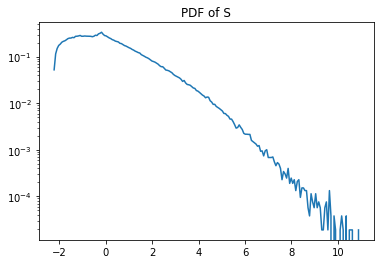

In [28]:
## Example
Ftmp,Stmp=getFluxThreshold(makeImage('large',noise_avg=noise_avg),ex3,True)

In [13]:
## Get threshold for S in case of Gaussian matched filter, same input and options as above
def getFluxThresholdGauss(image,tsig,showPDF=False):
    print "Getting Sth in Gaussian approx:"
    mf=crossCorrelate(image,tsig)
    Sth=np.percentile(mf.flatten(),(1-beta)*100.0)
    print "Sth =","%.2g"%Sth,"\n"
    if showPDF:
        hist,bin_edges=np.histogram(mf.flatten(),200,density=True)
        plt.plot(bin_edges[:-1],hist)
        plt.yscale('log')
        plt.title("PDF of S - Gaussian case")
        plt.show()
    return Sth

Getting Sth in Gaussian approx:
Sth = 0.026 



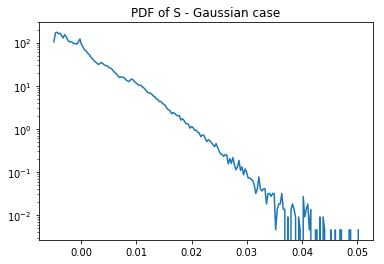

In [ ]:
## Example
Stmp=getFluxThresholdGauss(makeImage('large',noise_avg=noise_avg),ex3,True)

<a id='CompleteCode'></a>

** Full Code usage example **

Getting Fth and Sth:
Fth = 100
SF = 4.04718422007
Sth = 21.9107729851
Fth_new = 5.4188313933 

Fth = 5.4188313933
SF = 1.54680937935
Sth = 7.48240742841
Fth_new = 4.84231707882 

Fth = 4.84231707882
SF = 1.46824902091
Sth = 7.08095111713
Fth_new = 4.8277180923 

Fth = 4.83 Sth = 7.08 

Getting Sth in Gaussian approx:
Sth = 0.025 

Checking completeness for 1000 tries
SignalFlux / Completeness / Completeness - GaussianApprox
0 / 0.001 / 0.001
0.5 / 0.031 / 0.026
1 / 0.177 / 0.133
2 / 0.577 / 0.422
3 / 0.874 / 0.732
4 / 0.964 / 0.902
5 / 0.991 / 0.965
7 /  1 / 0.996
10 /  1 /  1
15 /  1 /  1


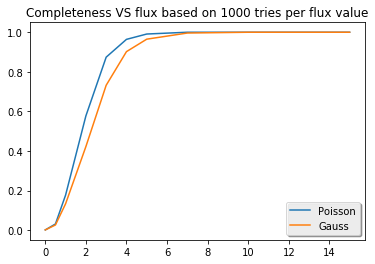

In [14]:
## Get signal template (normalized)
tsig=makeTemplate()

## Get image filled with bkg and mean substracted + noise_avg value
image,noise_avg=makeImage('large')

## Find threshold values for F and S
Fth,Sth=getFluxThreshold(image,tsig)

## Find threshold value for S in Gaussian approx
Sth_G=getFluxThresholdGauss(image,tsig)

## Get filter for Poisson case only, since in Gaussian case the filter is the template signal
filt=makeFilter(tsig,Fth)

## Calculate completeness for various flux values and compare to Gaussian case
print "Checking completeness for %s tries"%Ntries
print "SignalFlux","/","Completeness","/","Completeness - GaussianApprox"
fluxes=[0,0.5,1,2,3,4,5,7,10,15]
successrate=[]
successrate_G=[]
for flux in fluxes:
    Ntried=0
    countsuccess=0
    countsuccess_G=0
    while(Ntried!=Ntries):
        Ntried+=1
        
        ## Get simulated signal with relevant flux
        ssig=makeSimSignal(tsig,flux)
        
        ## Get 'small' image of "bkg + sim. signal - mean(bkg)" of the size of the template
        image=makeImage('small',ssig,noise_avg=noise_avg)
        
        ## Get sum of element by element multiplication of this image with filter (= S)
        S=getFiltNorm(image,filt)
        
        ## Get sum of element by element multiplication of this image with template signal (= S_G)
        S_G=getFiltNorm(image,tsig)
        
        ## Count number of succeses
        if S>Sth:
            countsuccess+=1
        if S_G>Sth_G:
            countsuccess_G+=1
    print flux,"/","%2g"%(countsuccess/float(Ntries)),"/","%2g"%(countsuccess_G/float(Ntries))
    successrate.append(countsuccess/float(Ntries))
    successrate_G.append(countsuccess_G/float(Ntries))
    
## Make the plot
fig, ax = plt.subplots()
ax.plot(fluxes,successrate,label='Poisson')
ax.plot(fluxes,successrate_G,label='Gauss')
legend=ax.legend(shadow=True)
plt.title("Completeness VS flux based on %s tries per flux value"%Ntries);